# Census income classification with LightGBM

This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. This tutorial is based on the code from (https://github.com/slundberg/shap/tree/master/notebooks).

LightBGM stands for Light Gradient Boosted Machines. It is a gradient boosting tree-based algorithm that is suitable for prediction problems with different types of inputs such as in UCI Adult income dataset used in this example. 

As LightBGM is a tree-based algorithm, Tree SHAP ([arXiv paper](https://arxiv.org/abs/1802.03888)) can be used to compute SHAP values efficiently.In this exmaple, we will train a LightBGM model and use SHAP values to explain the decision of the model on invidual samples and on the entire dataset. 

## text below is from original exercise
Gradient boosting machine methods such as LightGBM are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP ([arXiv paper](https://arxiv.org/abs/1802.03888)) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ LightGBM code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand LightGBM model predictions. 

## Install requirements 
Install shap and lighgbm

conda install -c conda-forge shap lightgbm 

In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# Include the SHAP javascript so that interactive graph below works
shap.initjs()

## Load dataset

In [7]:
X,y = shap.datasets.adult() # load the dataset for traniing
X_display,y_display = shap.datasets.adult(display=True) # for categories display strings instead of category codes

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train) # initialize the dataset for lightgbm
d_test = lgb.Dataset(X_test, label=y_test)

## Train the model

In [8]:
#setting learning parameters
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


## Explain predictions

TreeExplainer uses TreeSHAP to explain the decisions of the model

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Visualize a single prediction

Note that we use the "display values" data frame so we get nice strings instead of category codes. 

In [6]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

Shapley values in this example can be considered as forces that increases or decreases the likelihood of the predition. In this example, the person score is lower than the base value (average of all preditions) -2.433. The factors that pushed him towards the lower predition for >50K valuation is the low captail gain, and not having a family. 

### Visualize many predictions (1,000 instances)

To keep the browser happy we only visualize 1,000 individuals.

In [7]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

## SHAP Summary Plot with mean SHAP values

The diagram below shows the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart. Features are sorted by the average SHAP values from highest to lowerest. Relationship feature most impact on the model predictions and country has the least. 



### the text below is from origial tutorial pointless.
#shap.summary_plot(shap_values, X_display, plot_type="bar")

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

The plot displays the absolute value of the Shapley values of each feature (Shapley values can be negative or positive)

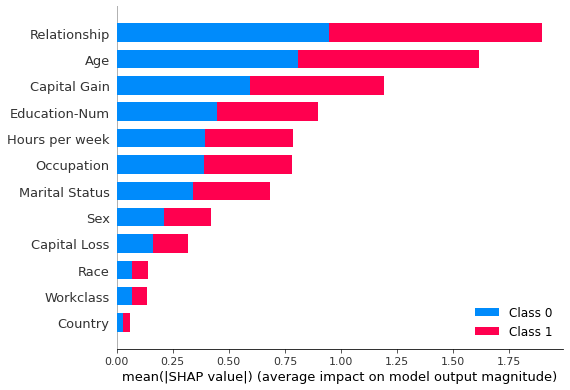

In [11]:
shap.summary_plot(shap_values, X)
#shap.summary_plot(shap_values, X_display, plot_type="bar") this two codes are the same

## SHAP Dependence Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. 

The components of the dependence plot are as follows 
* Each dot is a single prediction (row) from the dataset.
* The x-axis is the value of the feature (from the X matrix).
* The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. For this model the units are log-odds of making over 50k annually.
* The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. For the example below 20-year-olds with a high level of education are less likely make over 50k than 20-year-olds with a low level of education. This suggests an interaction effect between Education-Num and Age.

#### unsed text below
The dependence plots that follows shows the feature's value on the horizontal axis and shte shap value of that feature across many samples on the vertical axis. 

The colors of the feature indicates interaction effect with another feature (on the right vertical axis) 

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

SHAP feature dependence might be the simplest global interpretation plot: 1) Pick a feature. 2) For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. 3) Done.

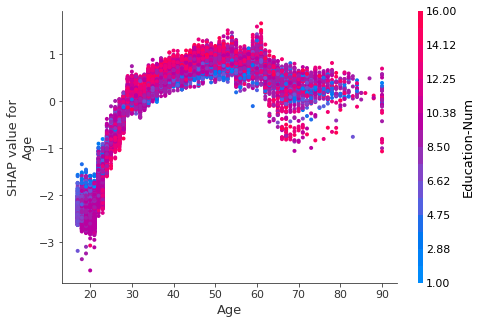

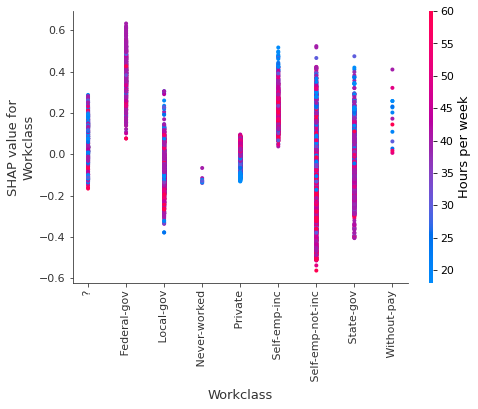

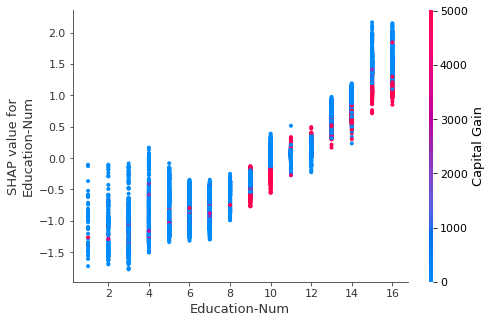

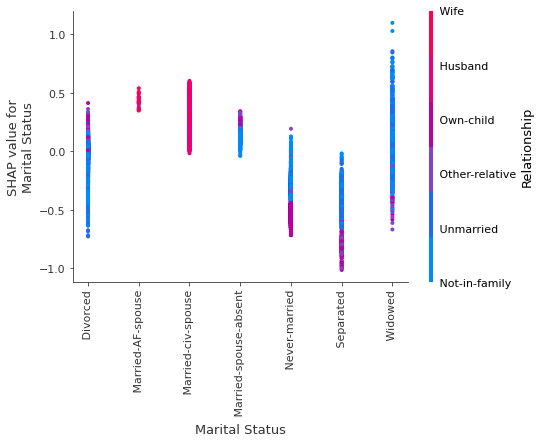

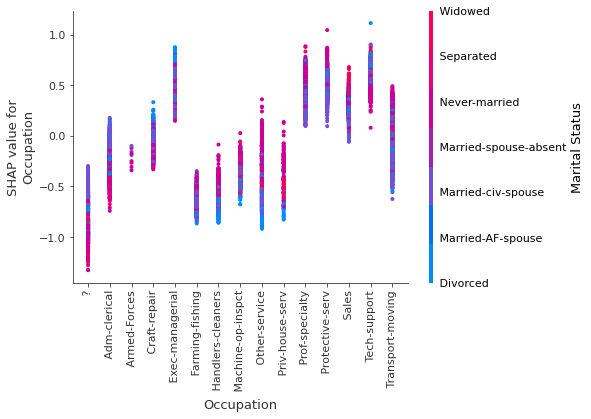

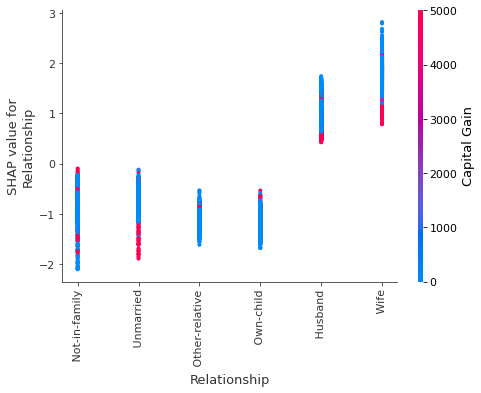

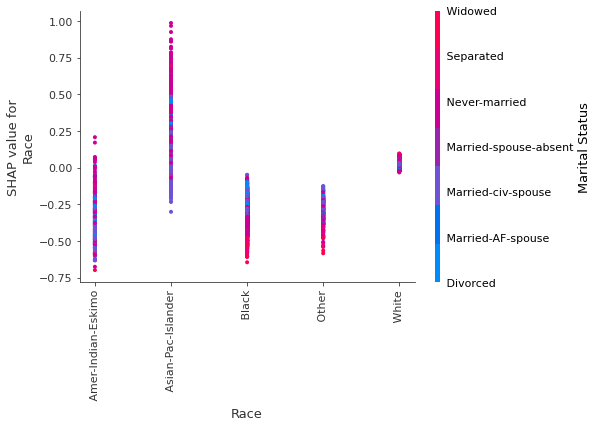

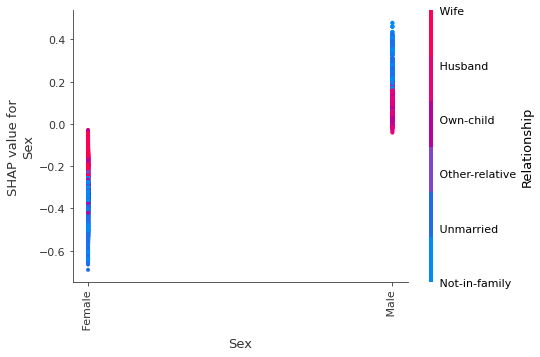

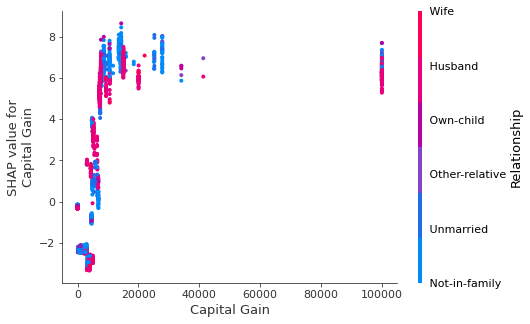

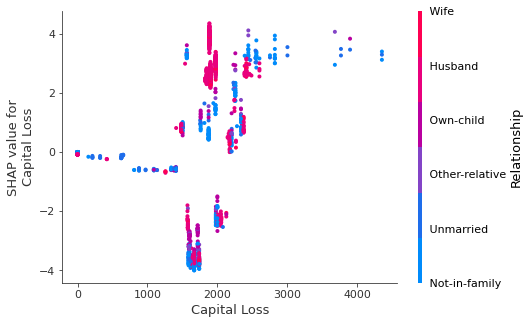

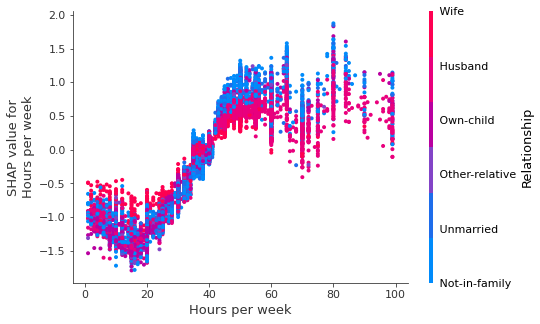

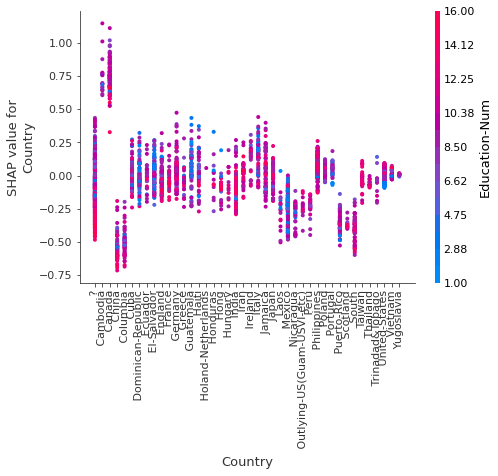

In [9]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)

### Train a model with only two leaves per tree and hence no interaction terms between features

Forcing the model to have no interaction terms means the effect of a feature on the outcome does not depend on the value of any other feature. This is reflected in the SHAP dependence plots below as no vertical spread. A vertical spread reflects that a single value of a feature can have different effects on the model output depending on the context of the other features present for an individual. However, for models without interaction terms, a feature always has the same impact regardless of what other attributes an individual may have.

One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.

In [10]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model_ind = lgb.train(params, d_train, 20000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's binary_logloss: 0.29538
[2000]	valid_0's binary_logloss: 0.289283
[3000]	valid_0's binary_logloss: 0.286626
[4000]	valid_0's binary_logloss: 0.284987
[5000]	valid_0's binary_logloss: 0.283784
[6000]	valid_0's binary_logloss: 0.282935
[7000]	valid_0's binary_logloss: 0.28226
[8000]	valid_0's binary_logloss: 0.281723
Early stopping, best iteration is:
[7958]	valid_0's binary_logloss: 0.281714


In [11]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Note that the interaction color bars below are meaningless for this model because it has no interactions.

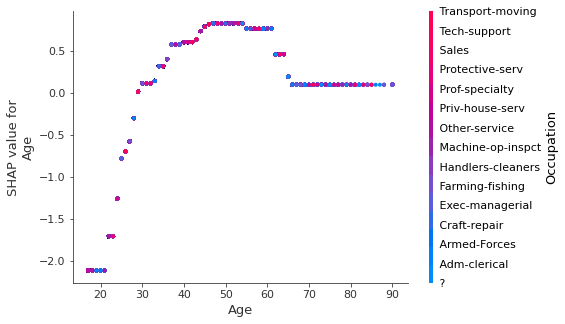

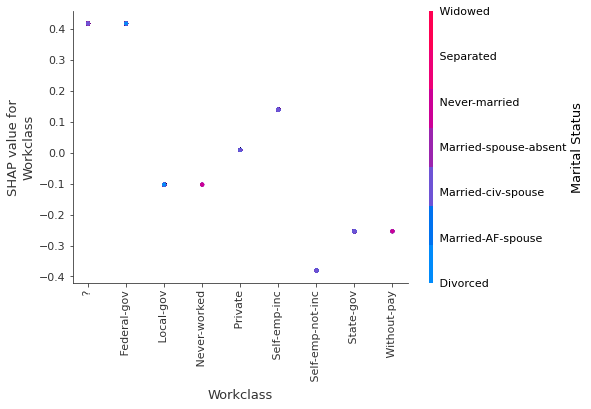

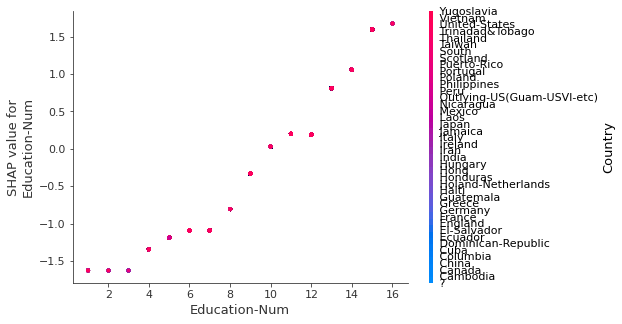

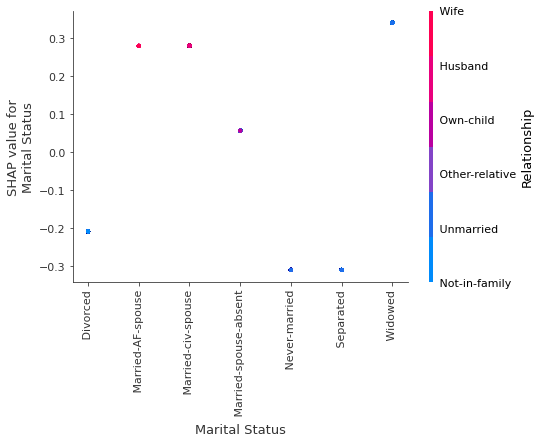

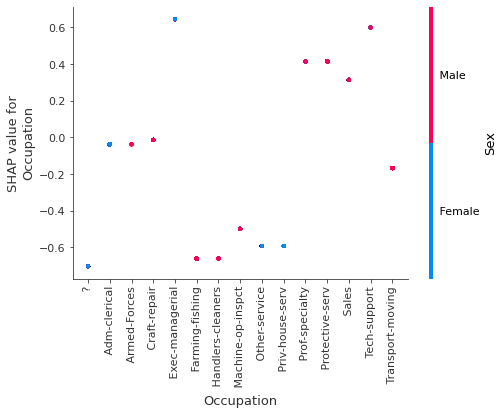

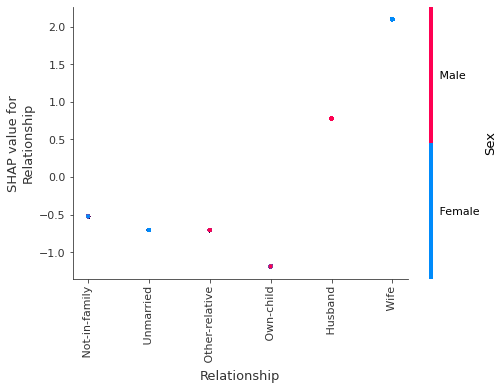

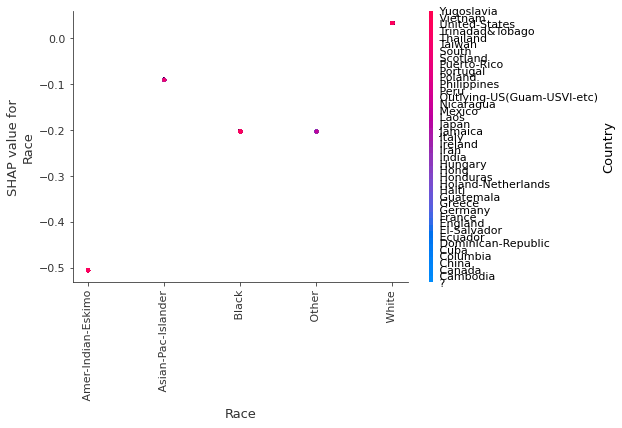

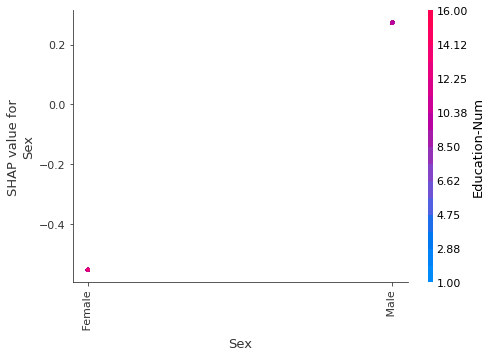

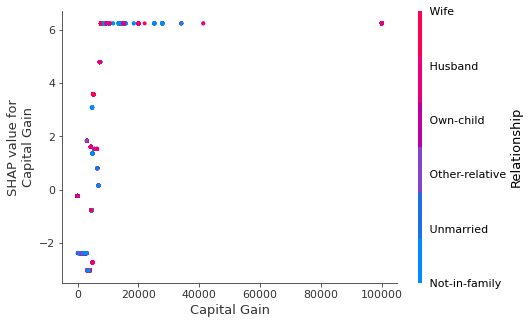

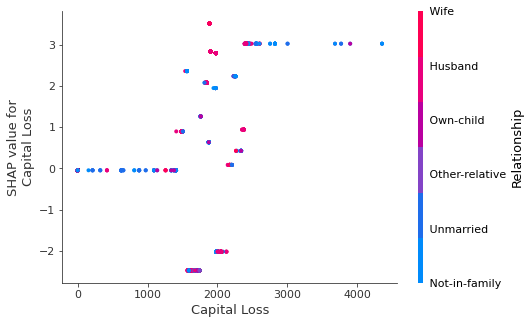

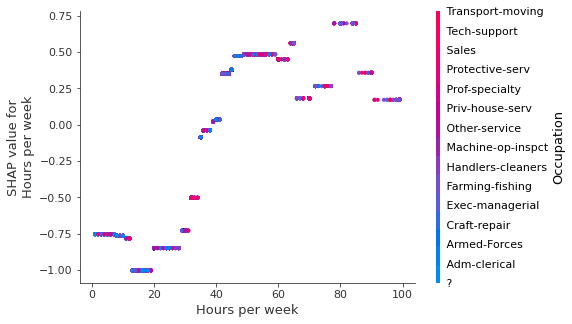

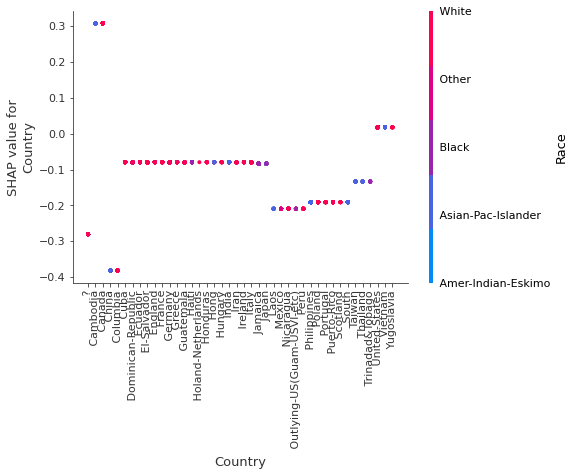

In [12]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind[1], X, display_features=X_display)